In [1]:
import sys
sys.path.append("..")

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from time import localtime, strftime, strptime
import os
from D2.data_selector import DataSelector
import seaborn as sns

SEED = 42

In [2]:
ds = DataSelector("../D2/data.csv")
data = ds.select_data(30000, length=5, scale_sd=1.5, seed=SEED)
data['conversation'] = data['conversation'].astype(str)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/VAD/M1.5/../D2/data_selector.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filepath)


Filtering...
Calculating counts...
Grabbing data...


In [3]:
raw_dataset = Dataset.from_pandas(data)
train_testval = raw_dataset.train_test_split(test_size=0.2, seed=SEED)
test_val = train_testval['test'].train_test_split(test_size=0.5, seed=SEED)

dataset = DatasetDict({
    'train': train_testval['train'],
    'test': test_val['test'],
    'val': test_val['train']}
)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def mask_data(mask_ratio):
    def mask_function(examples):
        mask_idx = np.random.choice(len(examples["text"]), int(mask_ratio * len(examples["text"])), replace=False)
        convs = examples["text"]
        for i in mask_idx:
            convs[i][-1] = tokenizer.mask_token
        
        return {"text": convs}

    return mask_function

def preprocess_data(examples):
    role_names = ("speaker", "respondent")

    convs = [
        tokenizer.apply_chat_template(
            [{"role": role_names[i % 2], "content": x} for i, x in enumerate(m)], 
            tokenize=False)
        for m in examples["text"]
    ]

    encoding = tokenizer(convs, max_length=512, truncation=True)
    encoding["labels"] = list(zip(examples["V"], examples["A"], examples["D"]))

    return encoding

test_dataset = dataset["test"].map(mask_data(0), batched=True, batch_size=100000)
tokenized_test_dataset = test_dataset.map(preprocess_data, batched=True, batch_size=100000)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



In [17]:
def get_checkpoint(epoch=0, run="latest", folder_path="results"):
    if run == "latest":
        run = max(os.listdir(folder_path), key=lambda x: strptime(x, "%b-%d-%y-%H:%M:%S"))

    checkpoint = sorted(os.listdir(f"{folder_path}/{run}"), key=lambda x: int(x.split("-")[1]))[epoch-1]

    return f"{folder_path}/{run}/{checkpoint}"

# c = get_checkpoint(3, "Dec-31-23-19:08:36")
c = get_checkpoint(3)
model = AutoModelForSequenceClassification.from_pretrained(c)

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = 4/(1+np.exp(-logits)) + 1

    metrics = {
        "mae": mean_absolute_error(labels, logits, multioutput="raw_values").tolist(),
        "mse": mean_squared_error(labels, logits, multioutput="raw_values").tolist(),
        "pearsonr": [pearsonr(logits[:, i], labels[:, i])[0] for i in range(len(logits[0]))],
        "r_squared": r2_score(labels, logits, multioutput="raw_values").tolist(),
    }

    return {f"{m}_{s}": metrics[m][i] for i, s in enumerate("VAD") for m in metrics}

In [7]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs['logits']) * 4 + 1
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [18]:
training_args = TrainingArguments(
    output_dir="/tmp/tmp_trainer",
    per_device_eval_batch_size=32,
    report_to="none",
)

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [19]:
trainer.evaluate(tokenized_test_dataset)

  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_loss': 0.030016105622053146,
 'eval_mae_V': 0.16482628881931305,
 'eval_mse_V': 0.054285455495119095,
 'eval_pearsonr_V': 0.9404363774281901,
 'eval_r_squared_V': 0.8388256048197675,
 'eval_mae_A': 0.1190187856554985,
 'eval_mse_A': 0.026068339124321938,
 'eval_pearsonr_A': 0.9297533279070096,
 'eval_r_squared_A': 0.8029670596323404,
 'eval_mae_D': 0.06976645439863205,
 'eval_mse_D': 0.009694531559944153,
 'eval_pearsonr_D': 0.8981113354809507,
 'eval_r_squared_D': 0.744300396277896,
 'eval_runtime': 11.8571,
 'eval_samples_per_second': 253.013,
 'eval_steps_per_second': 7.928}

In [20]:
predictions = trainer.predict(tokenized_test_dataset)

  0%|          | 0/94 [00:00<?, ?it/s]

In [21]:
preds = pd.DataFrame(dataset["test"])[["text", "V", "A", "D"]]
preds[["V_hat", "A_hat", "D_hat"]] = 4/(1+np.exp(-predictions[0])) + 1

In [22]:
preds

,text,V,A,D,V_hat,A_hat,D_hat
0,"[Did you drive up from San Francisco?, Yes., I...",3.012351,2.921960,3.015815,3.104980,2.901854,3.017623
1,[That's good. R u staying over Thurs or headin...,2.837051,2.996358,2.986176,2.923233,2.949986,2.961369
2,[What time are you planning on heading up ther...,3.009540,2.875494,3.024813,2.970474,2.896017,2.987613
3,"[In the long-run? Nothing worthwhile., In the ...",2.874461,3.012701,2.927805,2.802218,2.963946,2.909845
4,[hahaha. pharmacy drama...if it weren't for pa...,3.506263,3.712488,3.096389,4.022384,3.831491,3.123614
...,...,...,...,...,...,...,...
2995,"[Well don't worry, I can do much more than piz...",3.393228,3.585005,3.207707,3.698385,3.709593,3.199198
2996,[We're waiting for the Phlash near Penn's Land...,2.804574,2.947581,3.004175,3.008599,2.958467,3.032936
2997,"[Is it a big cemetery?, Yeah. It's huge. Redla...",2.250206,3.198032,2.625693,2.182813,3.136462,2.500031
2998,"[Well, we got the DEA coming down here again, ...",3.015650,2.923265,3.057716,3.058458,2.883597,3.052978


In [23]:
preds_it = preds.iterrows()

Costume building
Sweet, what for? I teach costume sometimes. Sewing's my main skill.
Cosplay lol it's japanese
Awesome. I'm teaching a medieval cardboard warfare camp. People keep comparing it to LARPing.
Awesome!!, That's really cool! Where at??


[(1.0, 5.0)]

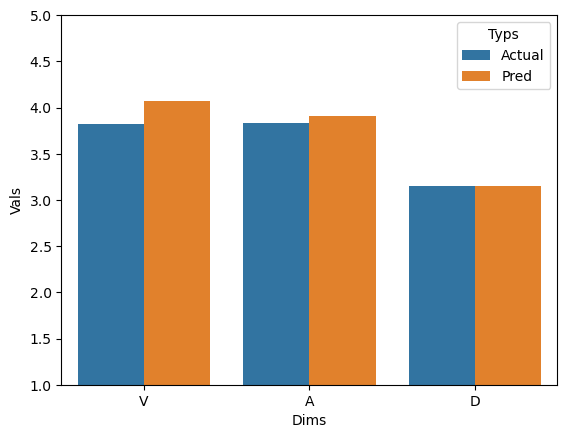

In [65]:
row = next(preds_it)[1]
for i in row["text"]: print(i)

vals = row[list("VAD")].tolist() + [row["V_hat"], row["A_hat"], row["D_hat"]]
dims = list("VAD") * 2
typs = ["Actual"] * 3 + ["Pred"] * 3
bar_df = pd.DataFrame({"Vals": vals, "Dims": dims, "Typs": typs})

ax = sns.barplot(bar_df, x="Dims", y="Vals", hue="Typs",)
ax.set(ylim=(1, 5))

<Axes: xlabel='D', ylabel='D_hat'>

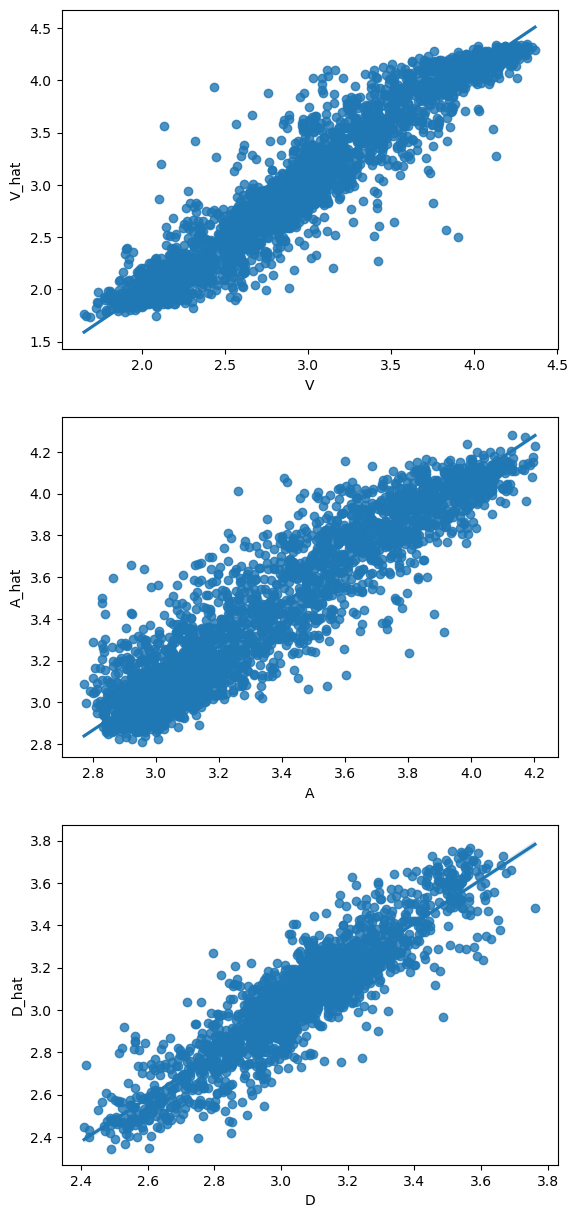

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3)
fig.set_figheight(15)
sns.regplot(preds, x="V", y="V_hat", ax=axs[0])
sns.regplot(preds, x="A", y="A_hat", ax=axs[1])
sns.regplot(preds, x="D", y="D_hat", ax=axs[2])

In [16]:
def loop():
    fig, axs = plt.subplots(nrows=20, ncols=3)
    fig.set_figwidth(20)
    fig.set_figheight(100)

    for i in range(1, 21):
        c = get_checkpoint(i)
        model = AutoModelForSequenceClassification.from_pretrained(c)

        trainer = RegressionTrainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        predictions = trainer.predict(tokenized_dataset["test"])
        preds = pd.DataFrame(dataset["test"]).drop(["id", "split"], axis=1)[["text", "V", "A", "D"]]
        preds[["V_hat", "A_hat", "D_hat"]] = 4/(1+np.exp(-predictions[0])) + 1

        sns.regplot(preds, x="V", y="V_hat", ax=axs[i-1][0])
        sns.regplot(preds, x="A", y="A_hat", ax=axs[i-1][1])
        sns.regplot(preds, x="D", y="D_hat", ax=axs[i-1][2])



NameError: name 'tokenized_dataset' is not defined

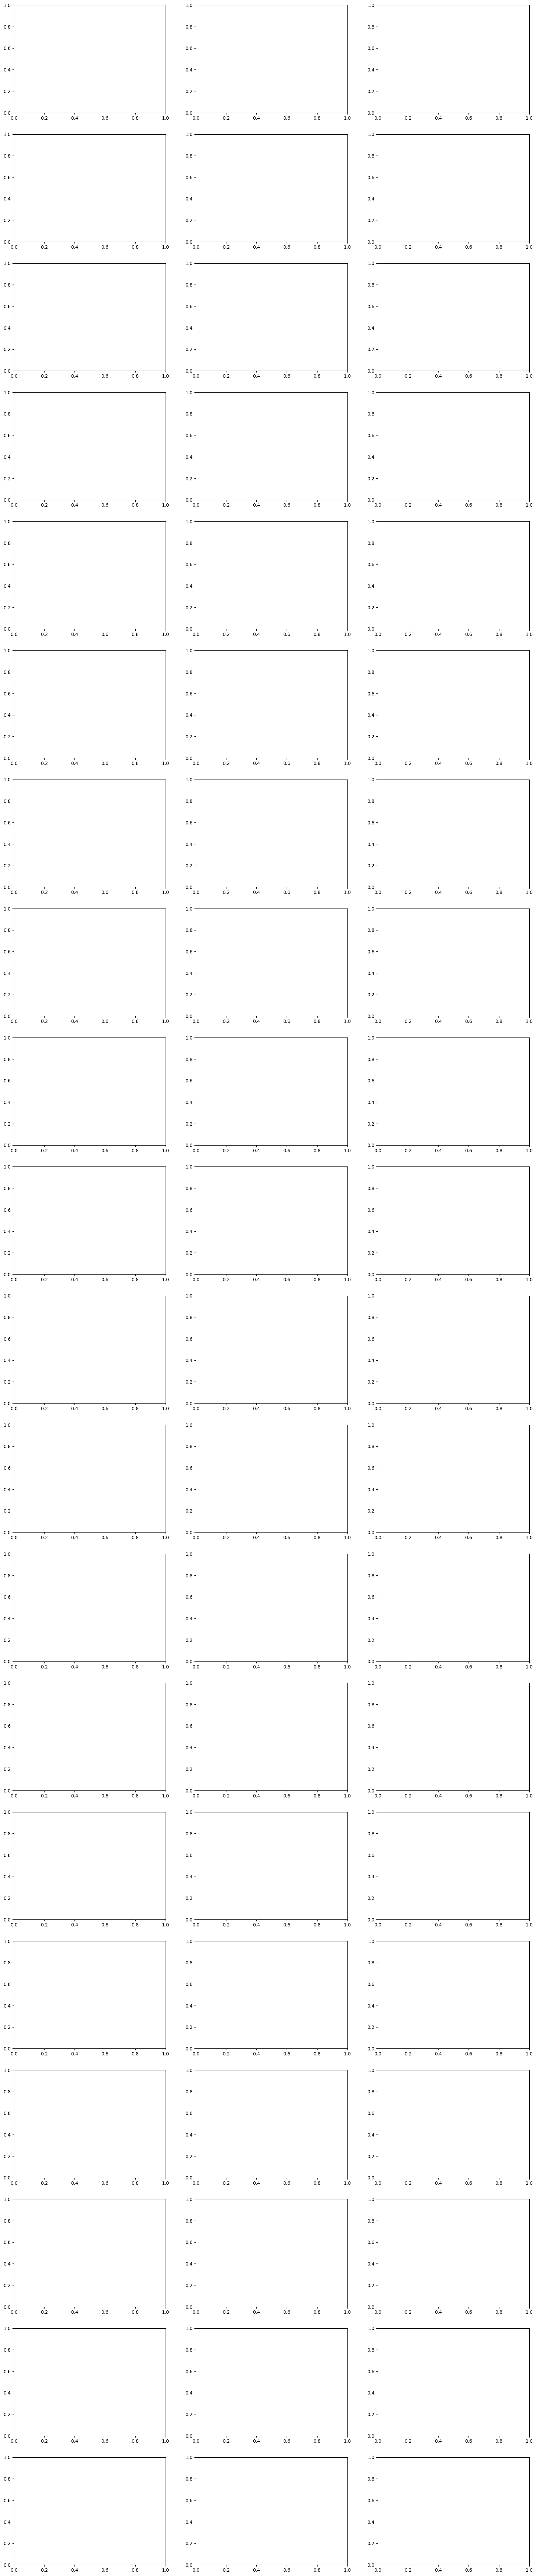

In [17]:
loop()

In [66]:
c = get_checkpoint(3)
model = AutoModelForSequenceClassification.from_pretrained(c)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [94]:
text_inputs = [
    [
        "i just lost my job today. it's devastating", 
        "i just found a job today, i'm so happy", 
        "this is miserable. i feel like a failure.", 
        "i can't believe my good fortune!",
        "will you just shut up?",
    ], [
        "I just got a promotion at work! I'm so excited and proud of myself!",
        "Wow, that's fantastic news! Congratulations! 🎉",
        "Thanks! It's been a long journey, but I finally feel recognized for my efforts.",
        "I can imagine the hard work you've put in. Your dedication has paid off. How do you feel now?",
        "well actually, i feel sad",
    ], [
        "i just lost everything that mattered to me. there's no point in life anymore", 
        "life is meaningless anyways", 
        "what should i do now? what can i even do now", 
        "it's hopeless. there's no point in doing anything. life is sad",
        "yeah",
    ], [
        "i just lost everything that mattered to me. there's no point in life anymore", 
        "don't worry, i got you. look at all these good things!", 
        "oh wow, thanks! what should i do now? i'm happy", 
        "just stay optimistic. don't give up.",
        "yeah",
    ],
]

role_names = ["speaker", "respondent"]
text_inputs = [tokenizer.apply_chat_template(
                   [{"role": role_names[i % 2], "content": x} for i, x in enumerate(m)], 
                   tokenize=False)
              for m in text_inputs
]

In [95]:
from transformers import TextClassificationPipeline

class RegPipeline(TextClassificationPipeline):
    def postprocess(self, model_outputs):
        best_class = model_outputs["logits"]
        return torch.sigmoid(best_class) * 4 + 1
    
pipe = RegPipeline(model=model, tokenizer=tokenizer)

In [96]:
pipe(text_inputs)

[tensor([[2.3513, 3.4778, 3.0258]]),
 tensor([[1.9067, 3.4729, 2.3674]]),
 tensor([[2.5518, 3.0359, 2.8733]]),
 tensor([[2.8778, 2.9722, 2.9646]])]

In [101]:
trainer.callback_handler.on_epoch_end

<bound method CallbackHandler.on_epoch_end of <transformers.trainer_callback.CallbackHandler object at 0x7f540e47ab50>>